In [78]:
import sys
import os
import re
import numpy as np
import torch
from torch.multiprocessing import Process, set_start_method
from functools import partial
from utils import record_stats, display_stats, distribute
from pathlib import Path 


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
n_cpu = 16
n_instance = -1
nodesels = [ 'expert_dummy']
problem = 'FCMCNF'
normalize = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
verbose = True
on_log = False
default = True
delete = False

if delete:
    try:
        import shutil
        shutil.rmtree(os.path.join(os.path.abspath(''), 
                                       f'stats/{problem}'))
    except:
        ''



instances = list(Path(os.path.join(os.path.abspath(''), 
                                   f"./problem_generation/data/{problem}/test")).glob("*.lp"))
if n_instance == -1 :
    n_instance = len(instances)

instances = instances[:n_instance]

print("Evaluation")
print(f"  Problem:                    {problem}")
print(f"  n_instance/problem:         {len(instances)}")
print(f"  Nodeselectors evaluated:    {','.join( ['default' if default else '' ] + nodesels)}")
print(f"  Device for GNN inference:   {device}")
print(f"  Normalize features:         {normalize}")
print("----------------")




Evaluation
  Problem:                    FCMCNF
  n_instance/problem:         143
  Nodeselectors evaluated:    default,expert_dummy
  Device for GNN inference:   cuda
  Normalize features:         True
----------------


In [111]:
#Run benchmarks

processes = [  Process(name=f"worker {p}", 
                                target=partial(record_stats,
                                                nodesels=nodesels,
                                                instances=instances[p1:p2], 
                                                problem=problem,
                                                device=torch.device(device),
                                                normalize=normalize,
                                                verbose=verbose,
                                                default=default))
                for p,(p1,p2) in enumerate(distribute(n_instance, n_cpu)) ]  


try:
    set_start_method('spawn')
except RuntimeError:
    ''

a = list(map(lambda p: p.start(), processes)) #run processes
b = list(map(lambda p: p.join(), processes)) #join processes


------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=15_n_commodities=26_id_3.18.lp
   |----Nodesel: default
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=15_n_commodities=26_id_3.18.lp
   |----Nodesel: expert_dummy
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=18_n_commodities=20_id_8.14.lp
   |----Nodesel: default
------------------------------------------
   |----Solving:  FCMCNF
   |----Instance: /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=18_n_commodities=20_id_8.14.lp
   |----Nodesel: expert_dummy
------------------------------------------
   |----Solving:  FCMCNF
  

pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)


KeyboardInterrupt: 

pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)
pressed CTRL-C 1 times (5 times for forcing termination)


Statistics on FCMCNF for problem size in [16, 20]
  default 
      Mean over n=17 instances : 
        |- B&B Tree Size   :  435
        |- Solving Time    :  28.02
-------------------------------------------------
  estimate_estimate 
      Mean over n=17 instances : 
        |- B&B Tree Size   :  376
        |- Solving Time    :  28.42
        |- nodecomp calls  :  1848
        |- nodesel calls   :  415
-------------------------------------------------
  estimate_dummy 
      Mean over n=17 instances : 
        |- B&B Tree Size   :  345
        |- Solving Time    :  27.04
        |- nodecomp calls  :  2475
        |- nodesel calls   :  347
-------------------------------------------------
  expert_dummy 
      Mean over n=17 instances : 
        |- B&B Tree Size   :  198
        |- Solving Time    :  20.54
        |- nodecomp calls  :  1149
        |- nodesel calls   :  199
-------------------------------------------------
  gnn_dummy_nprimal=3 
      Mean over n=17 instances : 
    

[]

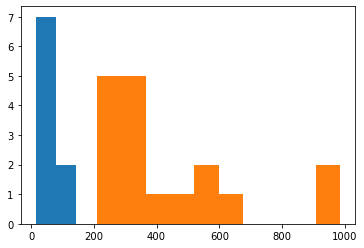

In [109]:
#print results
%reload_ext autoreload

nnode_means = display_stats(problem, nodesels, instances, min_n, max_n, default=default)


min_n = min([ int( str(instance).split('=')[1].split('_')[0] )  for instance in instances ] )
max_n = max([ int( str(instance).split('=')[1].split('_')[0] )  for instance in instances ] )

#print(nnode_means)

from matplotlib.pyplot import hist
hist(nnode_means['expert_dummy'].values())
hist(nnode_means['default'].values())


ins_to_delete = []
for ins in instances:
    instance = str(ins)
    if nnode_means['default'][instance] < 200:
        ins_to_delete.append(instance)

ins_to_delete

In [101]:
#delete unsolved instances or bad instances
        

for nodesel in nodesels:
    for ins in instances:
        instance = str(ins)
        name = instance.split('/')[-1].split('.lp')[0]
        if not os.path.isfile(f'stats/{problem}/{nodesel}/{name}.csv') or instance in ins_to_delete:
            try:
                print(f'deleting instance {instance}')
                os.remove(instance)
                os.remove(instance.replace('.lp', '.sol'))
            except:
                print('instance already deleted')
                

deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=19_n_commodities=22_id_71.41.lp
instance already deleted
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=19_n_commodities=27_id_9.68.lp
instance already deleted
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=17_n_commodities=29_id_13.27.lp
instance already deleted
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=18_n_commodities=23_id_19.42.lp
instance already deleted
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=18_n_commodities=28_id_32.54.lp
instance already deleted
deleting instance /local_workspace/labaabde/learn2selectnodes/problem_generation/data/FCMCNF/test/n_nodes=17_n_commodities=25_id_72.51.lp
instance already deleted
deleting instance /loca